Prikaz podatkov iz prvih dveh nalog:
Prejšnji rezultati klasifikacijskih modelov:
Točnost: 0.4777777777777778
Utežena F1 vrednost: 0.48194444444444445
Utežena preciznost: 0.5048839269891902
Utežen priklic: 0.4777777777777778

Točnost knn: 0.4888888888888889
Utežena knn F1 vrednost: 0.468919431458847
Utežena knn preciznost: 0.6520325203252032
Utežen knn priklic: 0.4888888888888889

Prejšnji rezultati regresijskih modelov:
Linear Regression Results:
Mean Absolute Error: 330.199401566806
Mean Squared Error: 193318.59897518498
R2 Score: 0.5538876263620081

Ridge Regression Results:
Mean Absolute Error: 330.1140665525415
Mean Squared Error: 193312.5620120243
R2 Score: 0.5539015575821775

/////////////////////////////////
Novi rezultati:
Rezultati za Bagging (Regression Problem):
	test_neg_mean_squared_error: 54828.636
	test_neg_mean_absolute_error: 138.692
	test_r2: 0.868


Rezultati za Random Forest (Regression Problem):
	test_neg_mean_squared_error: 48671.862
	test_neg_mean_absolute_error

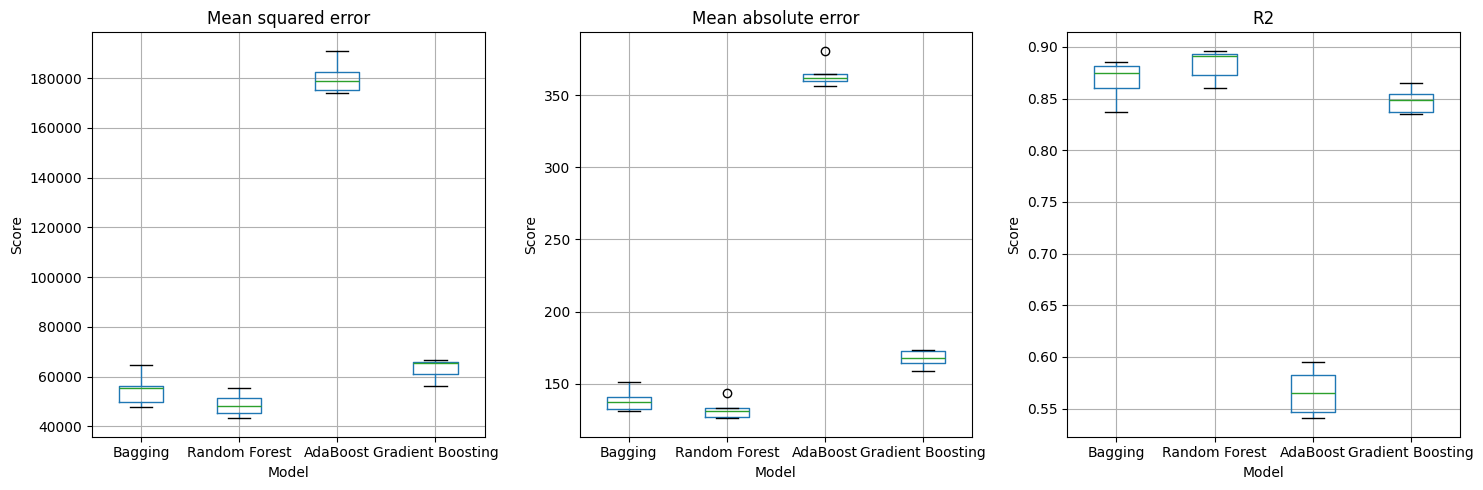

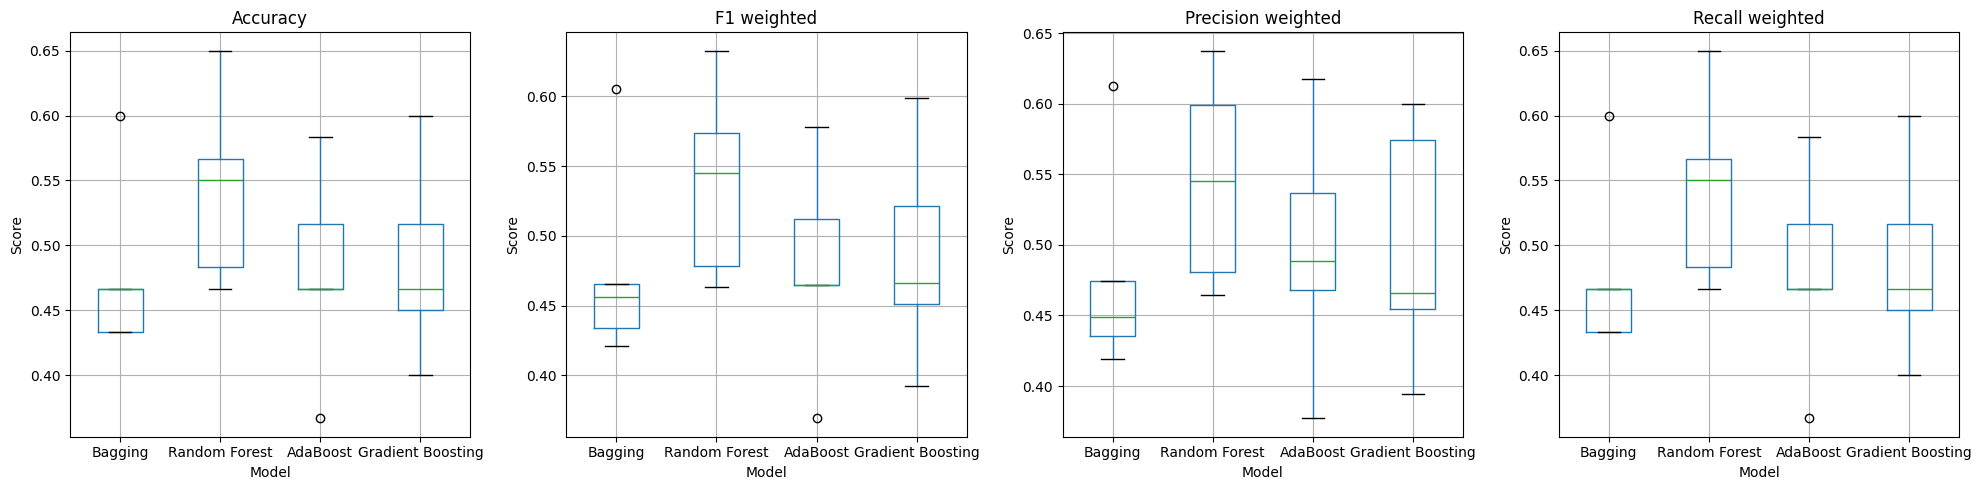

C:\Users\mitja\AppData\Local\Temp\ipykernel_21320\800449039.py:171: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax1.legend([ax1.get_legend(), ax2.get_legend(), ax3.get_legend()],


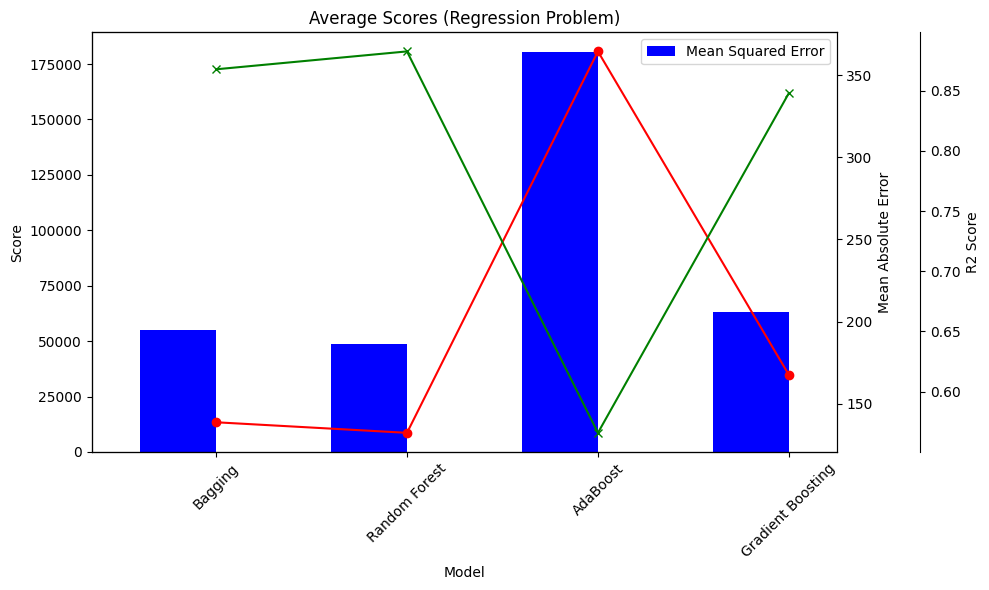

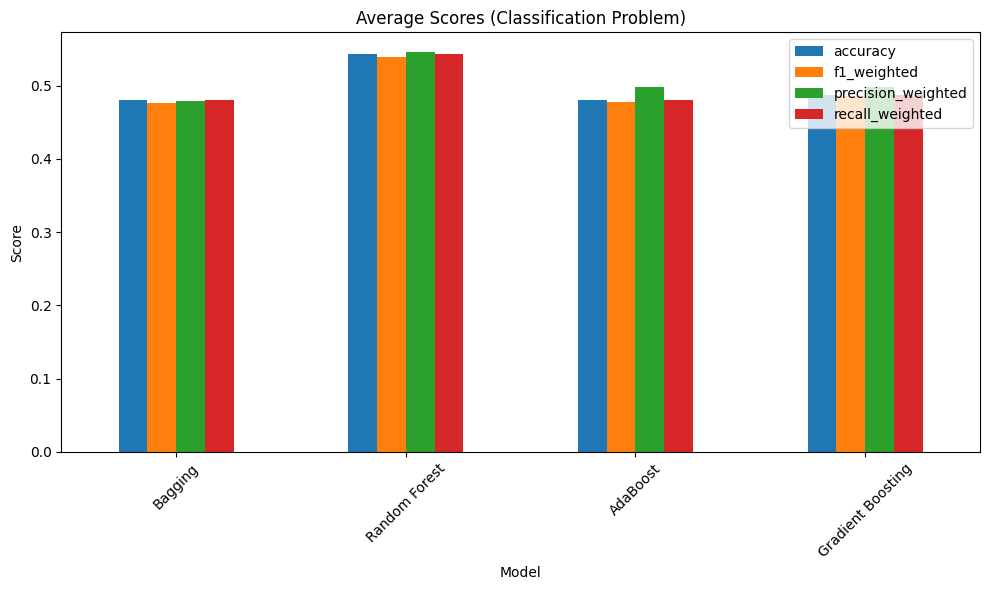

In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import KFold, cross_validate
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt


def load_and_preprocess_classification_data():
    data_dir = 'C:/Users/mitja/Desktop/shapes'
    categories = ['circles', 'squares', 'triangles']
    paths = []
    labels = []

    for i, category in enumerate(categories):
        category_dir = os.path.join(data_dir, category)
        for filename in os.listdir(category_dir):
            paths.append(os.path.join(category_dir, filename))
            labels.append(i)

    images = []
    for path in paths:
        img = Image.open(path).convert('L')
        img_array = np.array(img).flatten()
        images.append(img_array)

    X = np.array(images)
    y = np.array(labels)

    return X, y

def load_and_preprocess_regression_data():

    data = pd.read_csv('C:/Users/mitja/Desktop/bike_data.csv')


    for column in data.columns:
        if data[column].dtype in [np.float64, np.int64]:
            data[column].fillna(data[column].mean(), inplace=True)

    data['day'] = data['date'].str.split('/').str[0].astype(int)
    data['month'] = data['date'].str.split('/').str[1].astype(int)
    data['year'] = data['date'].str.split('/').str[2].astype(int)
    data.drop('date', axis=1, inplace=True)

    data = pd.get_dummies(data, columns=['seasons', 'holiday', 'work_hours'])

    return data


def build_regressor_models():
    models = {
        "Bagging": BaggingRegressor(random_state=1234, n_jobs=-1),
        "Random Forest": RandomForestRegressor(random_state=1234, n_jobs=-1),
        "AdaBoost": AdaBoostRegressor(random_state=1234),
        "Gradient Boosting": GradientBoostingRegressor(random_state=1234)
    }
    return models

def build_classifier_models():
    models = {
        "Bagging": BaggingClassifier(random_state=1234, n_jobs=-1),
        "Random Forest": RandomForestClassifier(random_state=1234, n_jobs=-1),
        "AdaBoost": AdaBoostClassifier(random_state=1234),
        "Gradient Boosting": GradientBoostingClassifier(random_state=1234)
    }
    return models

def evaluate_models(models, X, y, problem_type="regression"):
    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    results = {}

    for name, model in models.items():
        if problem_type == "regression":
            metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
        else:
            metrics = ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']
        
        cv_results = cross_validate(model, X, y, cv=kf, scoring=metrics)
        results[name] = cv_results

    return results

def print_model_results(results, problem_type="regression"):
    for model_name, model_scores in results.items():
        
        print(f"Rezultati za {model_name} ({problem_type.capitalize()} Problem):")
        for metric, scores in model_scores.items():
            if 'time' not in metric:
                avg_score = np.mean(scores)
                if avg_score > 0:
                    
                    print(f"\t{metric}: {avg_score:.3f}")
                else:
                    
                    print(f"\t{metric}: {avg_score*-1:.3f}")
                
        print("\n")




def plot_separate_scores(results, problem_type="regression"):
    metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'] if problem_type == "regression" else ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']
    metrics = [metric for metric in metrics if 'time' not in metric]
    num_metrics = len(metrics)
    fig, axes = plt.subplots(1, num_metrics, figsize=(5 * num_metrics, 5))
    
    if not isinstance(axes, np.ndarray):
        axes = [axes]

    for ax, metric in zip(axes, metrics):
        data = []
        for model_name, scores in results.items():
            
            if f'test_{metric}' in scores:
                score_values = scores[f'test_{metric}']
                if 'neg_' in metric:
                    score_values = -np.array(score_values)  
                data.append(pd.Series(score_values, name=model_name))
        
        combined_data = pd.concat(data, axis=1)
        combined_data.boxplot(ax=ax)
        ax.set_title(metric.replace('neg_', '').replace('test_', '').replace('_', ' ').capitalize())
        ax.set_xlabel('Model')
        ax.set_ylabel('Score')

    plt.tight_layout()
    plt.show()



def plot_average_scores(results, problem_type="regression"):
    avg_scores = {}
    for name, scores in results.items():
        avg_scores[name] = {metric: np.mean(values) if 'neg_' not in metric else -np.mean(values) for metric, values in scores.items() if 'time' not in metric}

    df_avg_scores = pd.DataFrame(avg_scores).T
    df_avg_scores.columns = [col.replace('test_', '').replace('neg_', '') for col in df_avg_scores.columns]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    if problem_type == "regression":
        df_avg_scores['mean_squared_error'].plot(kind='bar', color='blue', ax=ax1, width=0.4, position=1)

        ax2 = ax1.twinx()
        df_avg_scores['mean_absolute_error'].plot(kind='line', marker='o', color='red', ax=ax2)

        ax3 = ax1.twinx()
        ax3.spines['right'].set_position(('outward', 60))  
        df_avg_scores['r2'].plot(kind='line', marker='x', color='green', ax=ax3)

        ax1.set_ylabel('Mean Squared Error')
        ax2.set_ylabel('Mean Absolute Error')
        ax3.set_ylabel('R2 Score')

        ax1.legend([ax1.get_legend(), ax2.get_legend(), ax3.get_legend()], 
                   labels=['Mean Squared Error', 'Mean Absolute Error', 'R2 Score'], loc='upper right')
    else:
        df_avg_scores[['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']].plot(kind='bar', figsize=(10, 6), ax=ax1)

    ax1.set_title(f'Average Scores ({problem_type.capitalize()} Problem)')
    ax1.set_xlabel('Model')
    ax1.set_xticklabels(df_avg_scores.index, rotation=45)
    ax1.set_ylabel('Score')

    plt.tight_layout() 
    plt.show()




def main():
    
    regression_data = load_and_preprocess_regression_data()
    X_reg = regression_data.drop('rented_bike_count', axis=1)
    y_reg = regression_data['rented_bike_count']

    classification_data = load_and_preprocess_classification_data()
    X_cls, y_cls = classification_data

    
    regressor_models = build_regressor_models()
    classifier_models = build_classifier_models()

    
    regression_results = evaluate_models(regressor_models, X_reg, y_reg, problem_type="regression")
    classification_results = evaluate_models(classifier_models, X_cls, y_cls, problem_type="classification")

    # Prikaz starih rezultatov
    print("Prikaz podatkov iz prvih dveh nalog:")

    print("Prejšnji rezultati klasifikacijskih modelov:")
    print("Točnost: 0.4777777777777778")
    print("Utežena F1 vrednost: 0.48194444444444445")
    print("Utežena preciznost: 0.5048839269891902")
    print("Utežen priklic: 0.4777777777777778")
    print()
    print("Točnost knn: 0.4888888888888889")
    print("Utežena knn F1 vrednost: 0.468919431458847")
    print("Utežena knn preciznost: 0.6520325203252032")
    print("Utežen knn priklic: 0.4888888888888889")
    print()

    print("Prejšnji rezultati regresijskih modelov:")
    print("Linear Regression Results:")
    print("Mean Absolute Error: 330.199401566806")
    print("Mean Squared Error: 193318.59897518498")
    print("R2 Score: 0.5538876263620081")
    print()

    print("Ridge Regression Results:")
    print("Mean Absolute Error: 330.1140665525415")
    print("Mean Squared Error: 193312.5620120243")
    print("R2 Score: 0.5539015575821775")
    print()
    print("/////////////////////////////////")
    print("Novi rezultati:")


    print_model_results(regression_results, problem_type="regression")
    print_model_results(classification_results, problem_type="classification")
    print("/////////////////////////////////")

    # Vizualizacija metrik posebej
    plot_separate_scores(regression_results, problem_type="regression")
    plot_separate_scores(classification_results, problem_type="classification")

    # Vizualizacija povprečnih vrednosti metrik
    plot_average_scores(regression_results, problem_type="regression")
    plot_average_scores(classification_results, problem_type="classification")

if __name__ == "__main__":
    main()
